In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# If running in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output_path = 'output/models/'

In [ ]:
ls

drive/  sample_data/


In [ ]:
cd drive/MyDrive/RecSys_KB/Aleksis

/content/drive/MyDrive/RecSys_KB/Aleksis


In [ ]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

In [ ]:
movies.head()

,movieId,title,genres,abstracts,abstracts_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji is a 1995 American fantasy adventure f...,1
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men is a 1995 American romantic c...,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN,0
4,5,Father of the Bride Part II (1995),Comedy,NaN,0


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
print("Any null values in movies:\n" ,movies.isnull().sum())
print("Any null values in ratings train:\n ",ratings.isnull().sum())

Any null values in movies:
 movieId               0
title                 0
genres                0
abstracts          3040
abstracts_count       0
dtype: int64
Any null values in ratings train:
  userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [ ]:
len(movies)

9742

In [ ]:
len(movies['title'].unique())

9737

In [ ]:
ratings['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

In [ ]:
ratings['rating'].value_counts(ascending=False)

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [ ]:
ratings['userId'].value_counts(ascending=True)

userId
257      20
320      20
569      20
576      20
278      20
       ... 
274    1346
448    1864
474    2108
599    2478
414    2698
Name: count, Length: 610, dtype: int64

In [ ]:
ratings['movieId'].value_counts(ascending=True)

movieId
179073      1
160569      1
164280      1
171701      1
171759      1
         ... 
2571      278
593       279
296       307
318       317
356       329
Name: count, Length: 9724, dtype: int64

In [ ]:
movie_ratings_count = ratings['movieId'].value_counts(ascending=True)

In [ ]:
sum(ratings['movieId'].value_counts(ascending=True) == 1)

3446

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(ratings[['userId', 'movieId']], ratings[['rating']], stratify=ratings[['rating']], test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.10, random_state=42)

In [ ]:
users_train = X_train.userId.unique()
movies_train = X_train.movieId.unique()

In [ ]:
movies_with_enough_ratings = list(filter(lambda x: movie_ratings_count[x] >= 5, movies_train))

In [ ]:
len(movies_with_enough_ratings)

3649

In [ ]:
userid2idx = {o:i + 1 for i,o in enumerate(users_train)}
movieid2idx = {o:i + 1 for i,o in enumerate(movies_with_enough_ratings)}

In [ ]:
len(userid2idx), len(movieid2idx)

(610, 3649)

In [ ]:
idx2userid = {v:k  for k,v in userid2idx.items()}
idx2movieid = {v:k  for k,v in movieid2idx.items()}

In [ ]:
userid2idx[-1] = 0 # unk user
movieid2idx[-1] = 0 # unk movie

In [ ]:
def get_indexes(data):
    data['userId'] = data['userId'].apply(lambda x: userid2idx.get(x, 0))
    data['movieId'] = data['movieId'].apply(lambda x: movieid2idx.get(x, 0))

In [ ]:
movies

,movieId,title,genres,abstracts,abstracts_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji is a 1995 American fantasy adventure f...,1
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men is a 1995 American romantic c...,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN,0
4,5,Father of the Bride Part II (1995),Comedy,NaN,0
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,The Butler Bulldogs men's basketball team repr...,2
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"No Game No Life (Japanese: ノーゲーム・ノーライフ, Hepbur...",1
9739,193585,Flint (2017),Drama,Flint is a sedimentary cryptocrystalline form ...,1
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"Bungo Stray Dogs (Japanese: 文豪ストレイドッグス, Hepbur...",2


In [ ]:
movies['genres'].isna().any()

False

In [ ]:
genres = set()
for genre in movies['genres']:
    genres.update(genre.split('|'))

In [ ]:
genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [ ]:
le = OneHotEncoder()
le.fit(np.array(list(genres)).reshape(-1, 1))

OneHotEncoder()

In [ ]:
le.categories_

[array(['(no genres listed)', 'Action', 'Adventure', 'Animation',
        'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
        'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
        'Sci-Fi', 'Thriller', 'War', 'Western'], dtype='<U18')]

In [ ]:
le.transform([['Fantasy'], ['Children']]).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [ ]:
sum(le.transform([['Fantasy'], ['Children']]).toarray())

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
sum(le.transform(np.array(movies[movies['movieId'] == 1]['genres'].values[0].split('|')).reshape(-1, 1)).toarray())

array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [ ]:
movies

,movieId,title,genres,abstracts,abstracts_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji is a 1995 American fantasy adventure f...,1
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men is a 1995 American romantic c...,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN,0
4,5,Father of the Bride Part II (1995),Comedy,NaN,0
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,The Butler Bulldogs men's basketball team repr...,2
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"No Game No Life (Japanese: ノーゲーム・ノーライフ, Hepbur...",1
9739,193585,Flint (2017),Drama,Flint is a sedimentary cryptocrystalline form ...,1
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"Bungo Stray Dogs (Japanese: 文豪ストレイドッグス, Hepbur...",2


In [ ]:
movies

,movieId,title,genres,abstracts,abstracts_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji is a 1995 American fantasy adventure f...,1
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men is a 1995 American romantic c...,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN,0
4,5,Father of the Bride Part II (1995),Comedy,NaN,0
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,The Butler Bulldogs men's basketball team repr...,2
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"No Game No Life (Japanese: ノーゲーム・ノーライフ, Hepbur...",1
9739,193585,Flint (2017),Drama,Flint is a sedimentary cryptocrystalline form ...,1
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"Bungo Stray Dogs (Japanese: 文豪ストレイドッグス, Hepbur...",2


In [ ]:
movie2genre_vec = {}
for i, row in movies.iterrows():
    movie2genre_vec[row['movieId']] = sum(le.transform(np.array(row['genres'].split('|')).reshape(-1, 1)).toarray())

In [ ]:
movie2genre_vec[1]

array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [ ]:
class RatingsDataset(Dataset):
    def __init__(self, X, y):
        self.userId = X['userId']
        self.movieId = X['movieId']
        self.rating = y['rating']

    def __len__(self):
        return len(self.userId)

    def __getitem__(self, idx):
        userId     = self.userId.iloc[idx]
        movieId    = self.movieId.iloc[idx]
        genres     = movie2genre_vec[movieId]
        rating     = self.rating.iloc[idx]
        movieId = movieid2idx.get(movieId, 0)
        userId = userid2idx.get(movieId, 0)

        return userId, movieId, genres, rating

In [ ]:
train_data = RatingsDataset(X_train, y_train)
val_data = RatingsDataset(X_val, y_val)
test_data = RatingsDataset(X_test, y_test)

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
def train_step(model,
               data_generator,
               loss_fn,
               optimizer,
               device):

    model.train()

    train_loss = []

    for idx, (X_user, X_movie, X_genres, y) in enumerate(data_generator):
        y = y.view(-1, 1).float()
        X_user, X_movie, X_genres, y = X_user.to(device), X_movie.to(device), X_genres.to(device).float(), y.to(device)


        y_pred = model(X_user, X_movie, X_genres)
        loss = loss_fn(y_pred, y)
        train_loss.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if idx % 25000 == 0:
            print('Step', idx)



    return np.mean(train_loss)

def test_step(model,
              data_generator,
              loss_fn,
              device):
    model.eval()

    test_loss = []

    with torch.inference_mode():
        for X_user, X_movie, X_genres, y in data_generator:
            y = y.view(-1, 1).float()
            X_user, X_movie, X_genres, y = X_user.to(device), X_movie.to(device), X_genres.to(device).float(), y.to(device)


            y_pred = model(X_user, X_movie, X_genres)

            loss = loss_fn(y_pred, y)
            test_loss.append(loss.item())

    return np.mean(test_loss)

def train(model,
          train_data_generator,
          test_data_generator,
          optimizer,
          loss_fn,
          epochs,
          device,
          scheduler):

    results = {"train_loss": [],
               "test_loss": [],
    }

    model.to(device)

    best_loss = float('inf')

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss = train_step(model=model,
                                          data_generator=train_data_generator,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        end_time = timer()
        test_loss = test_step(model=model,
          data_generator=test_data_generator,
          loss_fn=loss_fn,
          device=device)
        scheduler.step(test_loss)

        if best_loss > test_loss:
            best_loss = test_loss
            print('Saving new best model.')
            model.save( output_path + model.name + ".pt")

        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)


        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"time: {(end_time-start_time):.4f} "
          f"Learning rate: {next(iter(scheduler.optimizer.param_groups))['lr']}"
        )

    return results

def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

In [ ]:
class MF_FNN(nn.Module):
    def __init__(self, num_users, num_movies, genres_dim=20, emb_size=32, n_hidden=32, name='model'):
        super(MF_FNN, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.movie_emb = nn.Embedding(num_movies, emb_size)
        self.lin1 = nn.Linear(emb_size*2 + genres_dim, n_hidden)
        self.lin2 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.5)
        self.name = name

        self.user_emb.weight.data.uniform_(0, 0.05)
        self.movie_emb.weight.data.uniform_(0, 0.05)
        # self.user_emb.data = nn.Parameter(
        #     torch.Tensor(np.random.randn(num_users, emb_size) * 0.01)
        # )
        # self.movie_emb.data = nn.Parameter(
        #     torch.Tensor(np.random.randn(num_movies, emb_size) * 0.01)
        # )

    def save(self, fileName):
        torch.save(self.state_dict(), fileName)

    def load(self, fileName, device):
        self.load_state_dict(torch.load(fileName, map_location=device))

    def forward(self, user, movie, genres):
        U = self.user_emb(user)
        M = self.movie_emb(movie)
        x = F.relu(torch.cat([U, M, genres], dim=1))
        x = self.drop1(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat ,y))

In [ ]:
model = MF_FNN(len(userid2idx), len(movieid2idx), emb_size=20, n_hidden=20, name="deep_mf_v1") # best 0.9504
loss = RMSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold=0.0001, threshold_mode='rel')

  0%|          | 0/20 [00:00<?, ?it/s]

Step 0
Saving new best model.
Epoch: 1 | train_loss: 1.3039 | test_loss: 0.9614 | time: 11.2968 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 2 | train_loss: 0.9755 | test_loss: 0.9554 | time: 3.7243 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 3 | train_loss: 0.9585 | test_loss: 0.9527 | time: 3.8046 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 4 | train_loss: 0.9502 | test_loss: 0.9524 | time: 5.0670 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 5 | train_loss: 0.9461 | test_loss: 0.9508 | time: 3.7325 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 6 | train_loss: 0.9423 | test_loss: 0.9493 | time: 3.7208 Learning rate: 0.001
Step 0
Epoch: 7 | train_loss: 0.9410 | test_loss: 0.9513 | time: 4.8180 Learning rate: 0.001
Step 0
Epoch: 8 | train_loss: 0.9384 | test_loss: 0.9519 | time: 3.8044 Learning rate: 0.0001
Step 0
Epoch: 9 | train_loss: 0.9325 | test_loss: 0.9507 | time: 3.7446 Learning rate: 0.0001
Step 0
Epoch: 10 | tra

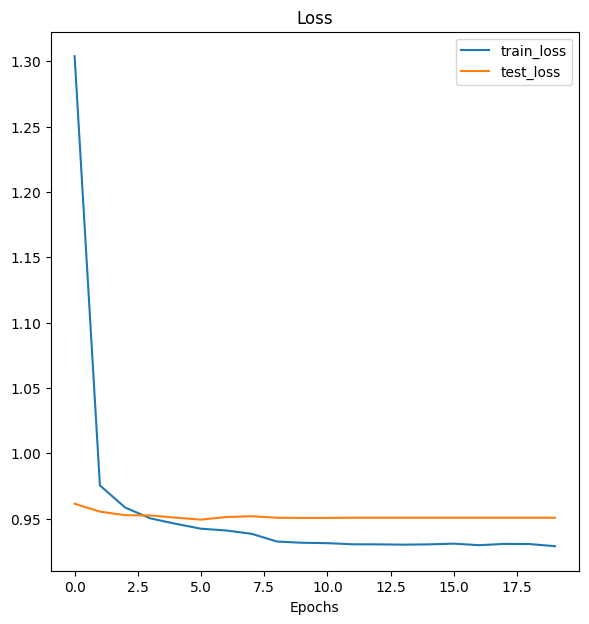

In [ ]:
results = train(model=model,
          train_data_generator = train_dataloader,
          test_data_generator = val_dataloader,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 20,
          device = device,
          scheduler=scheduler)
plot_loss_curves(results)

In [ ]:
movies

,movieId,title,genres,abstracts,abstracts_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji is a 1995 American fantasy adventure f...,1
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men is a 1995 American romantic c...,1
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,NaN,0
4,5,Father of the Bride Part II (1995),Comedy,NaN,0
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,The Butler Bulldogs men's basketball team repr...,2
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,"No Game No Life (Japanese: ノーゲーム・ノーライフ, Hepbur...",1
9739,193585,Flint (2017),Drama,Flint is a sedimentary cryptocrystalline form ...,1
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,"Bungo Stray Dogs (Japanese: 文豪ストレイドッグス, Hepbur...",2


In [ ]:
class MF_FNN2(nn.Module):
    def __init__(self, num_users, num_movies, genres_dim=20, emb_size=32, n_hidden=32, name="model"):
        super(MF_FNN2, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.movie_emb = nn.Embedding(num_movies, emb_size)
        self.lin1 = nn.Linear(emb_size*2 + genres_dim, n_hidden)
        self.lin2 = nn.Linear(n_hidden, n_hidden)
        self.lin3 = nn.Linear(n_hidden, 1)
        self.drop1 = nn.Dropout(0.5)
        self.drop2 = nn.Dropout(0.5)
        self.name = name

        self.user_emb.weight.data.uniform_(0, 0.05)
        self.movie_emb.weight.data.uniform_(0, 0.05)
        # self.user_emb.data = nn.Parameter(
        #     torch.Tensor(np.random.randn(num_users, emb_size) * 0.01)
        # )
        # self.movie_emb.data = nn.Parameter(
        #     torch.Tensor(np.random.randn(num_movies, emb_size) * 0.01)
        # )
    def save(self, fileName):
        torch.save(self.state_dict(), fileName)

    def load(self, fileName, device):
        self.load_state_dict(torch.load(fileName, map_location=device))

    def forward(self, user, movie, genres):
        U = self.user_emb(user)
        M = self.movie_emb(movie)
        x = F.relu(torch.cat([U, M, genres], dim=1))
        x = F.relu(self.lin1(x))
        x = self.drop1(x)
        x = F.relu(self.lin2(x)) + x
        x = self.drop2(x)
        x = self.lin3(x)
        return x

  0%|          | 0/20 [00:00<?, ?it/s]

Step 0
Saving new best model.
Epoch: 1 | train_loss: 1.6744 | test_loss: 1.0238 | time: 4.2204 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 2 | train_loss: 1.2018 | test_loss: 0.9855 | time: 4.7073 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 3 | train_loss: 1.1008 | test_loss: 0.9672 | time: 5.0893 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 4 | train_loss: 1.0301 | test_loss: 0.9588 | time: 4.1329 Learning rate: 0.001
Step 0
Epoch: 5 | train_loss: 0.9875 | test_loss: 0.9590 | time: 6.5927 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 6 | train_loss: 0.9662 | test_loss: 0.9568 | time: 4.0268 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 7 | train_loss: 0.9598 | test_loss: 0.9558 | time: 4.1279 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 8 | train_loss: 0.9555 | test_loss: 0.9549 | time: 5.1775 Learning rate: 0.001
Step 0
Epoch: 9 | train_loss: 0.9541 | test_loss: 0.9560 | time: 4.0547 Learning rate: 0.001
St

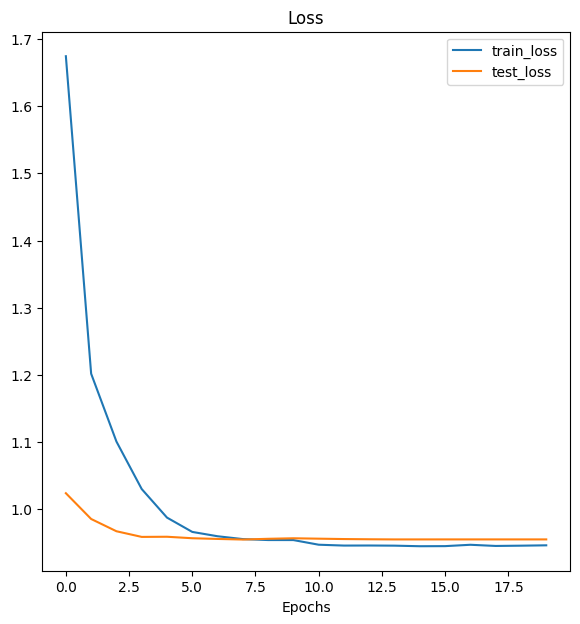

In [ ]:
model = MF_FNN2(len(userid2idx), len(movieid2idx), emb_size=20, n_hidden=20, name="deep_mf_v2") # best 0.9525
loss = RMSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold=0.0001, threshold_mode='rel')
results = train(model=model,
          train_data_generator = train_dataloader,
          test_data_generator = val_dataloader,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 20,
          device = device,
          scheduler=scheduler)
plot_loss_curves(results)

Trying without using the genres

In [ ]:
movie2genre_vec_copy = {}

In [ ]:
for k in movie2genre_vec:
    movie2genre_vec_copy[k] = movie2genre_vec[k][:]
    movie2genre_vec[k] = torch.zeros(20, dtype=torch.float)

In [ ]:
movie2genre_vec[1], movie2genre_vec_copy[1]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]))

  0%|          | 0/20 [00:00<?, ?it/s]

Step 0
Saving new best model.
Epoch: 1 | train_loss: 1.6246 | test_loss: 1.0028 | time: 3.9174 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 2 | train_loss: 1.2055 | test_loss: 0.9800 | time: 4.9435 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 3 | train_loss: 1.1102 | test_loss: 0.9726 | time: 4.0007 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 4 | train_loss: 1.0412 | test_loss: 0.9611 | time: 3.9083 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 5 | train_loss: 0.9969 | test_loss: 0.9594 | time: 4.9545 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 6 | train_loss: 0.9727 | test_loss: 0.9573 | time: 3.9045 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 7 | train_loss: 0.9629 | test_loss: 0.9560 | time: 3.9214 Learning rate: 0.001
Step 0
Epoch: 8 | train_loss: 0.9596 | test_loss: 0.9577 | time: 4.8898 Learning rate: 0.001
Step 0
Saving new best model.
Epoch: 9 | train_loss: 0.9555 | test_loss: 0.9559 | time: 4.0566 

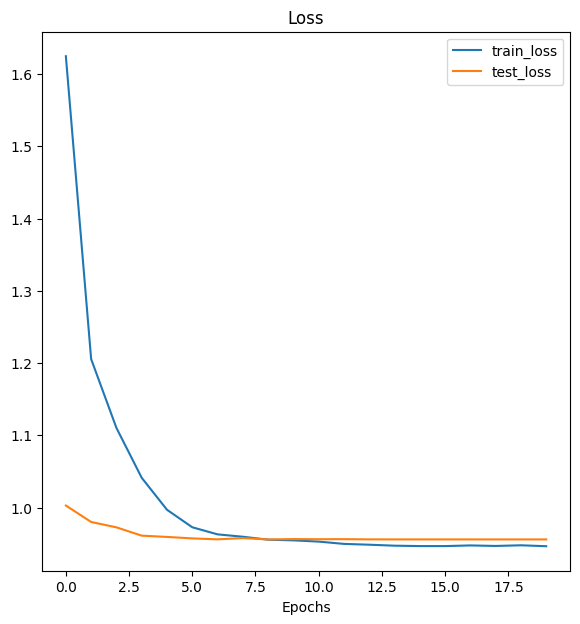

In [ ]:
model = MF_FNN2(len(userid2idx), len(movieid2idx), emb_size=20, n_hidden=20, name="deep_mf_v2_without_genres") # best 0.9688
loss = RMSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold=0.0001, threshold_mode='rel')
results = train(model=model,
          train_data_generator = train_dataloader,
          test_data_generator = val_dataloader,
          optimizer = optimizer,
          loss_fn = loss,
          epochs = 20,
          device = device,
          scheduler=scheduler)
plot_loss_curves(results)